In [12]:
###
# Plots are shown farther down - running these cells in order will generate them & the data necessary for them
# Analysis in README.md
###

import numpy as np
from numpy import genfromtxt

###
#Load data
###
data = genfromtxt('location_data_hw9_2018.csv', delimiter=',')[1:,:]


In [3]:
import pymc3 as pm

###
# Bayesian using Monte Carlo
### 

def getTrace(data,num_steps = 5000,sameSpeedQ = False,samples = "All"):
    """
    Returns results of Monte Carlo sampling for a linear fit to the red & blue particles x & y locations over time
    data: input data as a N x 5 numpy array, where N is the number of data points
    sameSpeedQ: Boolean, if set to True the Red and Blue particles will be assumed to have the same speed
    samples: String specifying number of data points to use, set to "All" or "100"
    """
    if samples=="100":
        my_data = np.copy(data[:100,:])
    else:
        my_data = np.copy(data)
    
    #put input data into desired form
    t = np.copy(my_data[:,0])
    rx = np.copy(my_data[:,1])
    ry = np.copy(my_data[:,2])
    bx = np.copy(my_data[:,3])
    by = np.copy(my_data[:,4])
    
    basic_model = pm.Model()

    with basic_model:
        # Priors for unknown model parameters: initial position, speed, and velocity angle for each particle
        rx0 = pm.Normal('rx0', mu=0, sd=10)
        ry0 = pm.Normal('ry0', mu=0, sd=10)
        rs = pm.Normal('rs', mu=0, sd=10)
        ra = pm.Normal('ra', mu=0, sd=2)
        bx0 = pm.Normal('bx0', mu=0, sd=10)
        by0 = pm.Normal('by0', mu=0, sd=10)
        if sameSpeedQ:
            bs = rs
        else:
            bs = pm.Normal('bs', mu=0, sd=10)
        ba = pm.Normal('ba', mu=0, sd=2)
        sigma = pm.HalfNormal('sigma', sd=1)
        
        #Define velocity components from speeds and angles
        rvx = rs*np.cos(ra)
        rvy = rs*np.sin(ra)
        bvx = bs*np.cos(ba)
        bvy = bs*np.sin(ba)

        # Expected value of outcome
        rx_exp = rx0 + rvx*t
        ry_exp = ry0 + rvy*t
        bx_exp = bx0 + bvx*t
        by_exp = by0 + bvy*t

        # Likelihood (sampling distribution) of observations
        rx_obs = pm.Normal('rx_obs', mu=rx_exp, sd=sigma, observed=rx)
        ry_obs = pm.Normal('ry_obs', mu=ry_exp, sd=sigma, observed=ry)
        bx_obs = pm.Normal('bx_obs', mu=bx_exp, sd=sigma, observed=bx)
        by_obs = pm.Normal('by_obs', mu=by_exp, sd=sigma, observed=by)

        step = pm.NUTS()
        trace = pm.sample(num_steps, step=step, njobs=4)
    return trace

In [10]:
import matplotlib.pyplot as plt 

def doPartsABGivenTrace(trace,sameSpeedQ = False,title_str = ""):
    """
    Calculates and prints results of a) - b) for given Monte Carlo output
    trace: MultiTrace object output of above Monte Carlo simulation
    title_str: String, will be printed as the title above the output
    """
    print(title_str)
    #Filter out values we don't wish to sample
    var_names = ['rs','ra','rx0','ry0','bs','ba','bx0','by0','sigma'] #list of variable names
    my_samples = {} #initiate dictionary
    for var in var_names:
        if sameSpeedQ and var == 'bs':
            my_samples['bs'] = trace['rs'][1000:][::5]
        else:
            my_samples[var] = trace[var][1000:][::5] #discard first 1000 steps, sample every 5 steps after that
    num_samples = len(my_samples[var_names[0]])

    #a) Plot posterior of the speed
    fig, axs = plt.subplots(1,2,sharey=True)

    rsp = my_samples['rs']
    bsp = my_samples['bs']
    axs[0].hist(rsp, bins=50, normed=True, label='MCMC posterior',color='r')
    axs[1].hist(bsp, bins=50, normed=True, label='MCMC posterior',color='b')
    axs[0].set_title("Red particle: speed")
    axs[1].set_title("Blue particle: speed")
    axs[0].set_ylabel("p(v)")
    axs[0].set_xlabel("v")
    axs[1].set_xlabel("v")

    fig.tight_layout()

    print("a) Posterior distributions for Red and Blue speeds:")
    plt.show()

    #b) Get crossing times for Red and Blue separately using simple algebra
    rct = -my_samples['ry0']/(my_samples['rs']*np.sin(my_samples['ra']))
    bct = -my_samples['by0']/(my_samples['bs']*np.sin(my_samples['ba']))
    bothct = np.max(np.asarray([rct,bct]),axis=0) #Take max of rct and bct to get time both have crossed
    bothct = np.sort(bothct) #sort to get confidence intervals
    bothct_CI = [bothct[int(num_samples*.05)],bothct[int(num_samples*.95)]]
    print("b) The .05-.95 confidence interval for the first time that both Red and Blue have crossed y = 0 is " + str(bothct_CI))

In [5]:
#Perform Monte Carlo for each of the 4 scenarios outlined in parts c) & d)
trace1 = getTrace(data,num_steps = 5000,sameSpeedQ = False,samples = "All")
trace2 = getTrace(data,num_steps = 5000,sameSpeedQ = True,samples = "All")
trace3 = getTrace(data,num_steps = 5000,sameSpeedQ = False,samples = "100")
trace4 = getTrace(data,num_steps = 5000,sameSpeedQ = True,samples = "100")

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_log__, ba, bs, by0, bx0, ra, rs, ry0, rx0]
100%|██████████| 5500/5500 [00:25<00:00, 216.06it/s]
The acceptance probability does not match the target. It is 0.938053210374, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.937688683704, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.946665220442, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.936107856876, but should be close to 0.8. Try to increase the number of tuning steps.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_log__, ba, by0, bx0, ra, rs, ry0, rx0]
100%|██████████| 5500/5500 [00:25<00:00, 213.24it/s]
The acceptance probability does not match the target. It is 0.94847520646, but should be close to 0.8. Try t

Different speeds, all measurements: 

a) Posterior distributions for Red and Blue speeds:


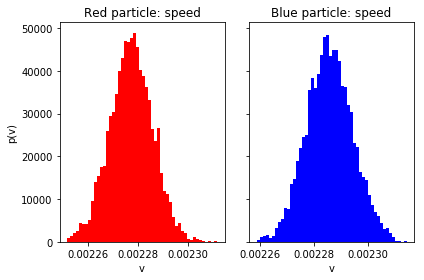

b) The .05-.95 confidence interval for the first time that both Red and Blue have crossed y = 0 is [572.93111269580902, 576.54343559896222]




Same speeds, all measurements: 

a) Posterior distributions for Red and Blue speeds:


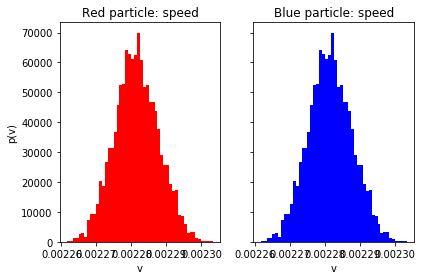

b) The .05-.95 confidence interval for the first time that both Red and Blue have crossed y = 0 is [573.13245744043468, 576.69970209536029]




Different speeds, 100 measurements: 

a) Posterior distributions for Red and Blue speeds:


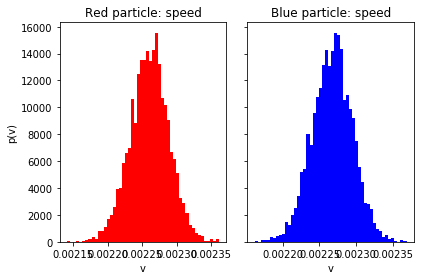

b) The .05-.95 confidence interval for the first time that both Red and Blue have crossed y = 0 is [570.36066081059403, 586.17923112608662]




Same speeds, 100 measurements: 

a) Posterior distributions for Red and Blue speeds:


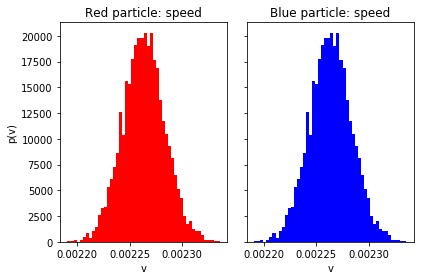

b) The .05-.95 confidence interval for the first time that both Red and Blue have crossed y = 0 is [572.60975497436471, 584.7406138591366]


In [11]:
#Print results
doPartsABGivenTrace(trace1,sameSpeedQ = False,title_str = "Different speeds, all measurements: \n")
print("\n\n\n")
doPartsABGivenTrace(trace2,sameSpeedQ = True,title_str = "Same speeds, all measurements: \n")
print("\n\n\n")
doPartsABGivenTrace(trace3,sameSpeedQ = False,title_str = "Different speeds, 100 measurements: \n")
print("\n\n\n")
doPartsABGivenTrace(trace4,sameSpeedQ = True,title_str = "Same speeds, 100 measurements: \n")

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
rx0,1.306865,0.007033,5.489172e-05,1.292937,1.320456,16730.0,1.000029
ry0,0.979495,0.006940,4.993587e-05,0.965919,0.992755,17786.0,0.999921
rs,0.002260,0.000028,1.928984e-07,0.002204,0.002315,18089.0,0.999917
ra,-1.467605,0.012617,9.144459e-05,-1.492478,-1.442760,16806.0,1.000087
bx0,1.091744,0.006867,5.068787e-05,1.078459,1.105299,19033.0,0.999914
by0,-1.300514,0.006808,4.324800e-05,-1.313438,-1.286673,18032.0,1.000045
bs,0.002267,0.000028,1.549488e-07,0.002213,0.002322,18354.0,1.000043
ba,1.448217,0.012291,1.066801e-04,1.424018,1.471638,18538.0,0.999984
sigma,0.036566,0.001309,9.295408e-06,0.034014,0.039150,20000.0,1.000028


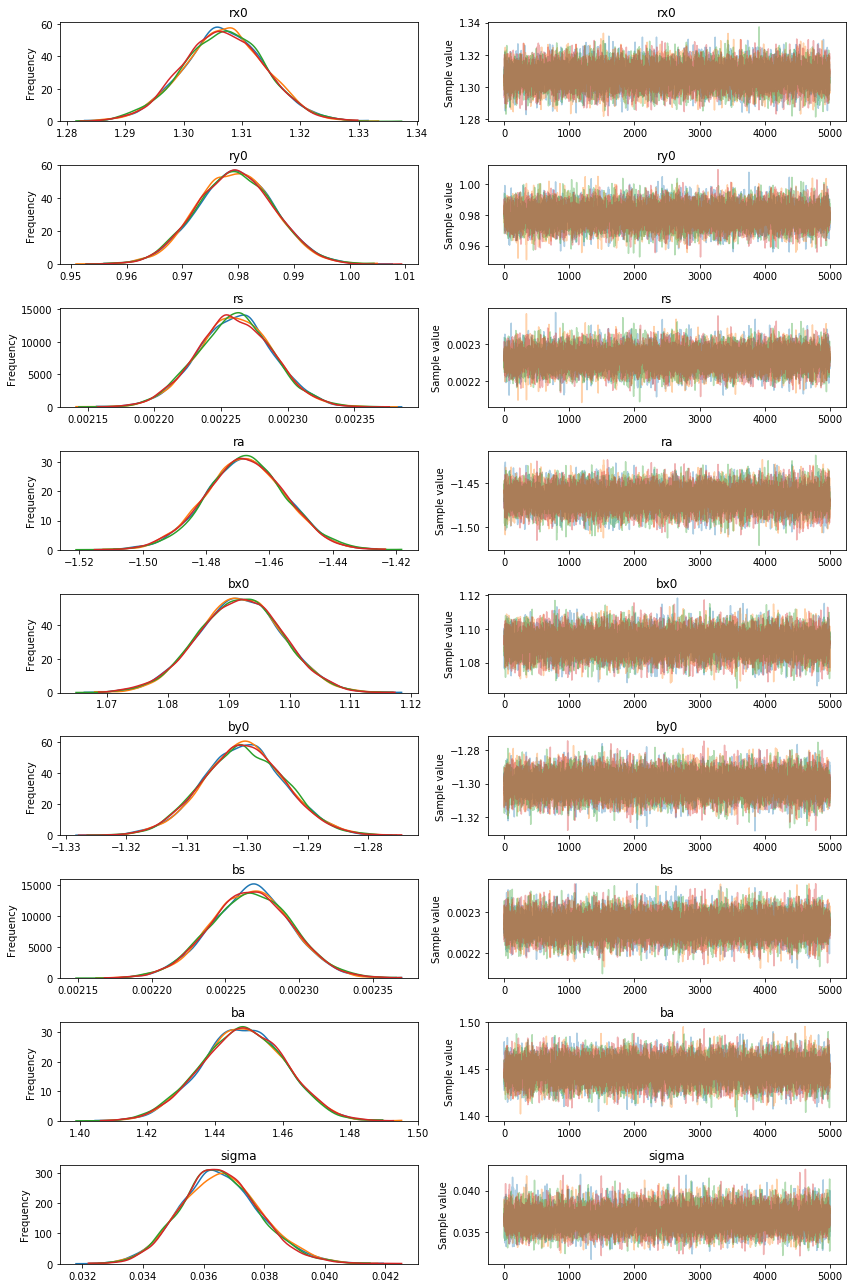

In [16]:
#Check convergence of results for, say, the 3rd scenario
#Looks pretty good! All 4 chains have very similar posterior distributions
plt.figure(figsize=(7, 7))
pm.traceplot(trace3)
plt.tight_layout();
pm.summary(trace3)